# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.061505,True,5.678408
1,-0.571968,False,0.182170
2,-0.442949,False,0.223714
3,0.081882,True,5.001486
4,0.320977,False,1.876747
...,...,...,...
995,0.852622,True,3.461659
996,-0.170277,False,-0.646575
997,-1.052003,False,0.169232
998,-0.726958,False,1.047659


<AxesSubplot: xlabel='v0'>

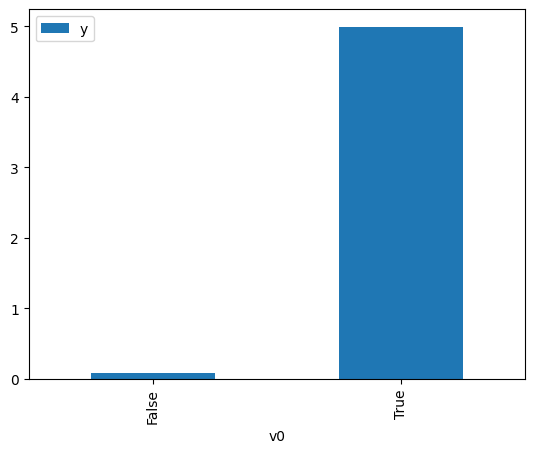

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

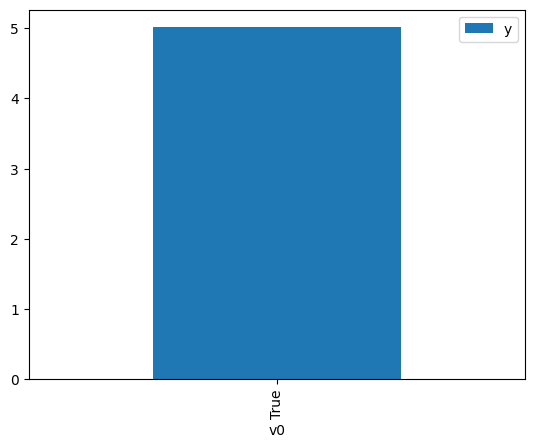

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.848749,False,0.811415,0.299530,3.338564
1,0.870071,False,1.565565,0.294277,3.398159
2,-1.281755,False,0.315402,0.840889,1.189218
3,0.505454,False,-0.863207,0.390697,2.559530
4,-1.582592,False,0.268038,0.882871,1.132668
...,...,...,...,...,...
995,-1.109200,False,-1.813000,0.811718,1.231955
996,1.144995,False,-0.059151,0.231624,4.317339
997,-1.485809,False,-0.937300,0.870533,1.148721
998,-0.464704,False,-0.637880,0.668317,1.496295


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-1.183905,True,4.595121,0.175176,5.708537
1,1.241459,True,5.138355,0.788016,1.269010
2,0.711120,True,4.159246,0.665323,1.503028
3,0.977236,True,6.000888,0.731290,1.367447
4,1.421338,True,5.332098,0.821318,1.217556
...,...,...,...,...,...
995,-0.275583,True,4.755949,0.382870,2.611856
996,0.070296,True,3.923744,0.482711,2.071633
997,0.722352,True,6.753931,0.668269,1.496404
998,1.551580,True,4.858910,0.842773,1.186559


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.930
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              6585.
Date:                Mon, 12 Dec 2022   Prob (F-statistic):                        0.00
Time:                        19:13:21   Log-Likelihood:                         -1437.9
No. Observations:                1000   AIC:                                      2880.
Df Residuals:                     998   BIC:                                      2890.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3889      0.036     10.881      0.000       0.319       0.459
x2             4.9510      0.050     98.467      0.000       4.852       5.050
==============================================================================
Omnibus:                        1.152   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.562   Jarque-Bera (JB):                1.212
Skew:                           0.048   Prob(JB):                        0.546
Kurtosis:                       2.860   Cond. No.                         1.79
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""